In [1]:
# source: https://nbviewer.org/github/niosus/notebooks/blob/master/icp.ipynb
import sys
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import animation, rc
from math import sin, cos, atan2, pi

In [8]:
def returnFinites(array):
    arr_isfinite = np.all(np.isfinite(array), axis=1)
    return array[arr_isfinite, :]

In [12]:
def plot_data(data_1, data_2, label_1, label_2, markersize_1=5, markersize_2=5):
    fig = plt.figure(figsize=(10, 6))
    ax = fig.add_subplot(111)
    ax.axis('equal')
    if data_1 is not None:
        x_p, y_p = data_1
        ax.scatter(x_p, y_p, color='#336699', s=markersize_1, marker='o', linestyle=":", label=label_1)
    if data_2 is not None:
        x_q, y_q = data_2
        ax.scatter(x_q, y_q, color='orangered', s=markersize_2, marker='o', linestyle=":", label=label_2)
    ax.legend()
    return ax

def plot_values(values, label):
    fig = plt.figure(figsize=(10, 4))
    ax = fig.add_subplot(111)
    ax.plot(values, label=label)
    ax.legend()
    ax.grid(True)
    plt.show()
    
def animate_results(P_values, Q, corresp_values, xlim, ylim):
    """A function used to animate the iterative processes we use."""
    fig = plt.figure(figsize=(10, 6))
    anim_ax = fig.add_subplot(111)
    anim_ax.set(xlim=xlim, ylim=ylim)
    anim_ax.set_aspect('equal')
    plt.close()
    x_q, y_q = Q
    # draw initial correspondeces
    corresp_lines = []
    for i, j in correspondences:
        corresp_lines.append(anim_ax.plot([], [], 'grey')[0])
    # Prepare Q data.
    Q_line, = anim_ax.plot(x_q, y_q, 'o', color='orangered')
    # prepare empty line for moved data
    P_line, = anim_ax.plot([], [], 'o', color='#336699')

    def animate(i):
        P_inc = P_values[i]
        x_p, y_p = P_inc
        P_line.set_data(x_p, y_p)
        draw_inc_corresp(P_inc, Q, corresp_values[i])
        return (P_line,)
    
    def draw_inc_corresp(points_from, points_to, correspondences):
        for corr_idx, (i, j) in enumerate(correspondences):
            x = [points_from[0, i], points_to[0, j]]
            y = [points_from[1, i], points_to[1, j]]
            corresp_lines[corr_idx].set_data(x, y)
    
    anim = animation.FuncAnimation(fig, animate,
                                   frames=len(P_values), 
                                   interval=500, 
                                   blit=True)
    return HTML(anim.to_jshtml())

def returnFinites(array):
    arr_isfinite = np.all(np.isfinite(array), axis=1)
    return array[arr_isfinite, :]

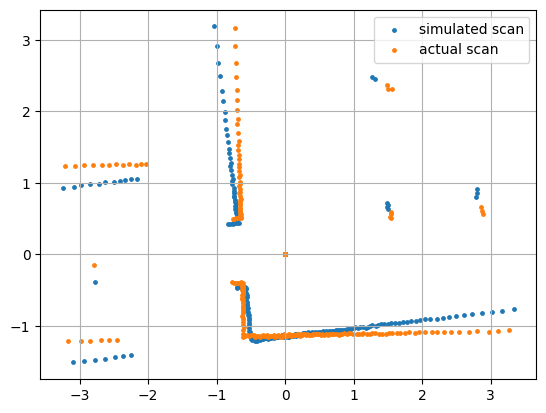

In [3]:
# saveFile = 'data_add/points_from_self_sim_ranges.npz'
# saveFile = 'data/points_from_sim_ranges_inf.npz'
saveFile = 'data_add/points_diff_scans.npz'
# saveFile = 'data_add/points_vdiff_scans.npz'

# load the two laser scans. they are already in a 4x1 format
diff_points_from_ranges = np.load(saveFile)
dspoints_p1_4x1 = returnFinites(diff_points_from_ranges['points_p1'])
dspoints_p2_4x1 = returnFinites(diff_points_from_ranges['points_p2'])

plt.figure()
plt.scatter(dspoints_p1_4x1[:, 0], dspoints_p1_4x1[:, 1], s = 6, label="simulated scan")
plt.scatter(dspoints_p2_4x1[:, 0], dspoints_p2_4x1[:, 1], s = 6, label="actual scan")

plt.grid(True)
plt.legend()
plt.show()

In [4]:
true_data = dspoints_p1_4x1[:, 0:2].T
# Move the data
moved_data = dspoints_p2_4x1[:, 0:2].T

# Assign to variables we use in formulas.
Q = true_data
P = moved_data

# plot_data(moved_data, true_data, "P: moved data", "Q: true data")
# plt.show()

In [5]:
def get_correspondence_indices(P, Q):
    """For each point in P find closest one in Q."""
    p_size = P.shape[1]
    q_size = Q.shape[1]
    correspondences = []
    for i in range(p_size):
        p_point = P[:, i]
        min_dist = sys.maxsize
        chosen_idx = -1
        for j in range(q_size):
            q_point = Q[:, j]
            dist = np.linalg.norm(q_point - p_point)
            if dist < min_dist:
                min_dist = dist
                chosen_idx = j
        correspondences.append((i, chosen_idx))
    return correspondences

def draw_correspondeces(P, Q, correspondences, ax):
    label_added = False
    for i, j in correspondences:
        x = [P[0, i], Q[0, j]]
        y = [P[1, i], Q[1, j]]
        if not label_added:
            ax.plot(x, y, color='grey', label='correpondences')
            label_added = True
        else:
            ax.plot(x, y, color='grey')
    ax.legend()

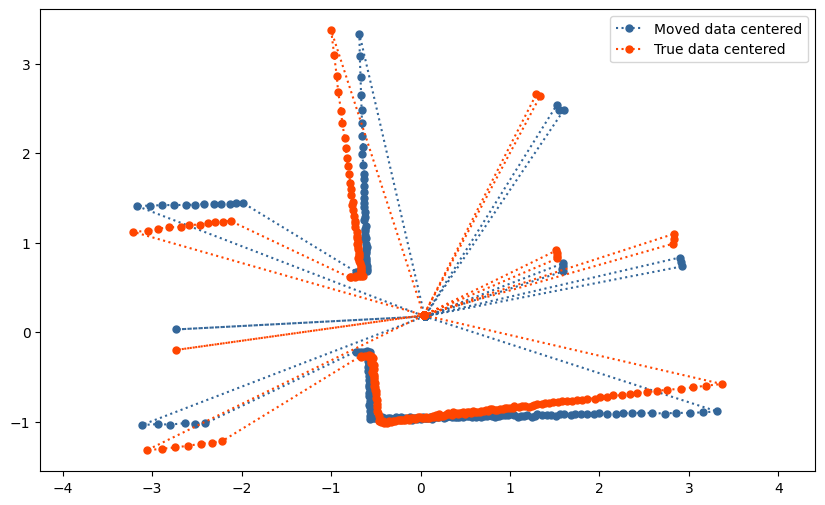

In [6]:
def center_data(data, exclude_indices=[]):
    reduced_data = np.delete(data, exclude_indices, axis=1)
    center = np.array([reduced_data.mean(axis=1)]).T
    return center, data - center

center_of_P, P_centered = center_data(P)
center_of_Q, Q_centered = center_data(Q)
ax = plot_data(P_centered, Q_centered,
               label_1='Moved data centered',
               label_2='True data centered')
plt.show()

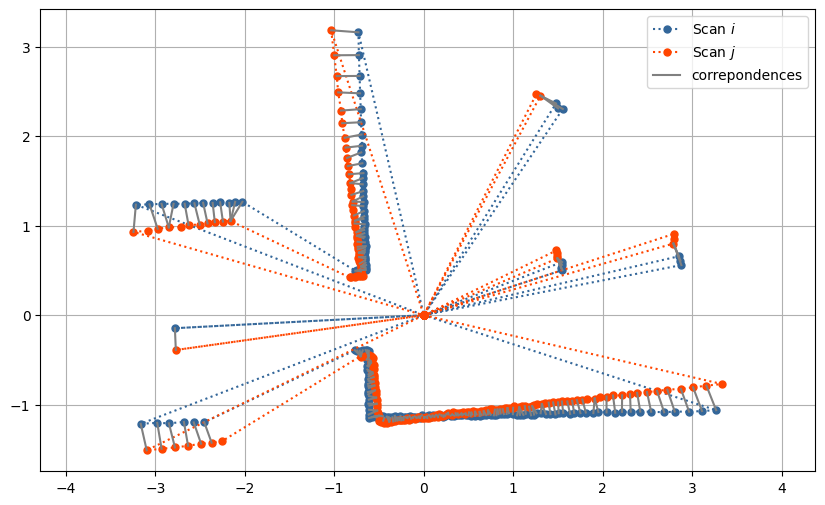

In [11]:
Pf = returnFinites(P)
Qf = returnFinites(Q)
correspondences = get_correspondence_indices(Pf, Qf)
ax = plot_data(Pf, Qf,
               label_1='Scan $i$',
               label_2='Scan $j$')
draw_correspondeces(Pf, Qf, correspondences, ax)
plt.grid(True)
plt.show()

In [ ]:
sum = 0
for i in correspondences:
    index_p = i[0]
    index_q = i[1]
    distance = np.linalg.norm(P[:, index_p] - Q[:, index_q])
    sum += distance
    print(P[:, index_p], "-", Q[:, index_q], " = ", distance)
print("Sum: ", sum)

In [ ]:
def compute_cross_covariance(P, Q, correspondences, kernel=lambda diff: 1.0):
    cov = np.zeros((2, 2))
    exclude_indices = []
    for i, j in correspondences:
        p_point = P[:, [i]]
        q_point = Q[:, [j]]
        weight = kernel(p_point - q_point)
        if weight < 0.01: exclude_indices.append(i)
        cov += weight * q_point.dot(p_point.T)
    return cov, exclude_indices

cov, _ = compute_cross_covariance(P_centered, Q_centered, correspondences)
print(cov)

In [ ]:
U, S, V_T = np.linalg.svd(cov)
print(S)
R_found = U.dot(V_T)
t_found = center_of_Q - R_found.dot(center_of_P)
print("R_found =\n", R_found)
print("t_found =\n", t_found)

In [ ]:
print(t_found)
print(R_found)
P_corrected = R_found.dot(P) + t_found
ax = plot_data(P_corrected, Q, label_1='P corrected', label_2='Q')
plt.show()
print("Squared diff: (P_corrected - Q) = ", np.linalg.norm(P_corrected - Q))

In [ ]:
def icp_svd(P, Q, iterations=10, kernel=lambda diff: 1.0):
    """Perform ICP using SVD."""
    center_of_Q, Q_centered = center_data(Q)
    norm_values = []
    P_values = [P.copy()]
    P_copy = P.copy()
    corresp_values = []
    exclude_indices = []
    for i in range(iterations):
        center_of_P, P_centered = center_data(P_copy, exclude_indices=exclude_indices)
        correspondences = get_correspondence_indices(P_centered, Q_centered)
        corresp_values.append(correspondences)
        norm_values.append(np.linalg.norm(P_centered - Q_centered))
        cov, exclude_indices = compute_cross_covariance(P_centered, Q_centered, correspondences, kernel)
        U, S, V_T = np.linalg.svd(cov)
        R = U.dot(V_T)  
        t = center_of_Q - R.dot(center_of_P)  
        P_copy = R.dot(P_copy) + t
        P_values.append(P_copy)
    corresp_values.append(corresp_values[-1])
    return P_values, norm_values, corresp_values

P_values, norm_values, corresp_values = icp_svd(P, Q)
plot_values(norm_values, label="Squared diff P->Q")
ax = plot_data(P_values[-1], Q, label_1='P final', label_2='Q', markersize_1=15)
plt.show()
print(norm_values)

In [ ]:
animate_results(P_values, Q, corresp_values, xlim=(-5, 35), ylim=(-5, 35))

In [ ]:
correspondences = get_correspondence_indices(P, Q)
ax = plot_data(P, Q, "Moved data", "True data")
draw_correspondeces(P, Q, correspondences, ax)
plt.show()

In [ ]:
def dR(theta):
    return np.array([[-sin(theta), -cos(theta)],
                     [cos(theta),  -sin(theta)]])

def R(theta):
    return np.array([[cos(theta), -sin(theta)],
                     [sin(theta),  cos(theta)]])

In [ ]:
def jacobian(x, p_point):
    theta = x[2]
    J = np.zeros((2, 3))
    J[0:2, 0:2] = np.identity(2)
    J[0:2, [2]] = dR(0).dot(p_point)
    return J

def error(x, p_point, q_point):
    rotation = R(x[2])
    translation = x[0:2]
    prediction = rotation.dot(p_point) + translation
    return prediction - q_point

In [ ]:
def prepare_system(x, P, Q, correspondences, kernel=lambda distance: 1.0):
    H = np.zeros((3, 3))
    g = np.zeros((3, 1))
    chi = 0
    for i, j in correspondences:
        p_point = P[:, [i]]
        q_point = Q[:, [j]]
        e = error(x, p_point, q_point)
        weight = kernel(e) # Please ignore this weight until you reach the end of the notebook.
        J = jacobian(x, p_point)
        H += weight * J.T.dot(J)
        g += weight * J.T.dot(e)
        chi += e.T * e
    return H, g, chi

def icp_least_squares(P, Q, iterations=30, kernel=lambda distance: 1.0):
    x = np.zeros((3, 1))
    chi_values = []
    x_values = [x.copy()]  # Initial value for transformation.
    P_values = [P.copy()]
    P_copy = P.copy()
    corresp_values = []
    for i in range(iterations):
        rot = R(x[2])
        t = x[0:2]
        correspondences = get_correspondence_indices(P_copy, Q)
        corresp_values.append(correspondences)
        H, g, chi = prepare_system(x, P, Q, correspondences, kernel)
        dx = np.linalg.lstsq(H, -g, rcond=None)[0]
        x += dx
        x[2] = atan2(sin(x[2]), cos(x[2])) # normalize angle
        chi_values.append(chi.item(0))
        x_values.append(x.copy())
        rot = R(x[2])
        t = x[0:2]
        P_copy = rot.dot(P.copy()) + t
        P_values.append(P_copy)
    corresp_values.append(corresp_values[-1])
    return P_values, chi_values, corresp_values

P_values, chi_values, corresp_values = icp_least_squares(P, Q)
plot_values(chi_values, label="chi^2")
print(chi_values)

In [ ]:
animate_results(P_values, Q, corresp_values, xlim=(-10, 35), ylim=(-10, 30))

In [ ]:
def compute_normals(points, step=1):
    normals = [np.array([[0, 0]])]
    normals_at_points = []
    for i in range(step, points.shape[1] - step):
        prev_point = points[:, i - step]
        next_point = points[:, i + step]
        curr_point = points[:, i]
        dx = next_point[0] - prev_point[0] 
        dy = next_point[1] - prev_point[1]
        normal = np.array([[0, 0],[-dy, dx]])
        normal = normal / np.linalg.norm(normal)
        normals.append(normal[[1], :])  
        normals_at_points.append(normal + curr_point)
    normals.append(np.array([[0, 0]]))
    return normals, normals_at_points

def plot_normals(normals, ax):
    label_added = False
    for normal in normals:
        if not label_added:
            ax.plot(normal[:,0], normal[:,1], color='grey', label='normals')
            label_added = True
        else:
            ax.plot(normal[:,0], normal[:,1], color='grey')
    ax.legend()
    return ax

Q_normals, Q_normals_to_draw = compute_normals(Q)
ax = plot_data(None, Q, None, 'Q')
ax = plot_normals(Q_normals_to_draw, ax)
plt.show()

In [ ]:
from sympy import init_printing, symbols, Matrix, cos as s_cos, sin as s_sin, diff
init_printing(use_unicode = True)

def RotationMatrix(angle):
    return Matrix([[s_cos(angle) , -s_sin(angle)], [s_sin(angle), s_cos(angle)]])

x, y, theta, n_x, n_y, p_x, p_y = symbols('x, y, \\theta, n_x, n_y, p_x, p_y')
t = Matrix([[x], [y]])
X = Matrix([x,y,theta])
n = Matrix([[n_x],[n_y]])
p = Matrix([[p_x], [p_y]])

error_point = RotationMatrix(theta) * p + t
error_normal = n.dot(RotationMatrix(theta) * p + t)

display()
J_point = diff(error_point, X).reshape(3,2).transpose()
J_normal = diff(error_normal, X).reshape(3,1).transpose()
display(Latex("Point to point Jacobian: "), J_point)
display(Latex("Point to plane Jacobian: "), J_normal)

In [ ]:
def prepare_system_normals(x, P, Q, correspondences, Q_normals):
    H = np.zeros((3, 3))
    g = np.zeros((3, 1))
    chi = 0
    for i, j in correspondences:
        p_point = P[:, [i]]
        q_point = Q[:, [j]]
        normal = Q_normals[j]
        e = normal.dot(error(x, p_point, q_point))
        J = normal.dot(jacobian(x, p_point))
        H += J.T.dot(J)
        g += J.T.dot(e)
        chi += e.T * e
    return H, g, chi

def icp_normal(P, Q, Q_normals, iterations=20):
    x = np.zeros((3, 1))
    chi_values = []
    x_values = [x.copy()]  # Initial value for transformation.
    P_values = [P.copy()]
    P_latest = P.copy()
    corresp_values = []
    for i in range(iterations):
        rot = R(x[2])
        t = x[0:2]
        correspondences = get_correspondence_indices(P_latest, Q)
        corresp_values.append(correspondences)
        H, g, chi = prepare_system_normals(x, P, Q, correspondences, Q_normals)
        dx = np.linalg.lstsq(H, -g, rcond=None)[0]
        x += dx
        x[2] = atan2(sin(x[2]), cos(x[2])) # normalize angle
        chi_values.append(chi.item(0)) # add error to list of errors
        x_values.append(x.copy())
        rot = R(x[2])
        t = x[0:2]
        P_latest = rot.dot(P.copy()) + t
        P_values.append(P_latest)
    corresp_values.append(corresp_values[-1])
    return P_values, chi_values, corresp_values

P_values, chi_values, corresp_values = icp_normal(P, Q, Q_normals)
plot_values(chi_values, label="chi^2")

In [ ]:
animate_results(P_values, Q, corresp_values, xlim=(-10, 35), ylim=(-10, 20))

In [ ]:
# Introduce an outlier.
P_outliers = P.copy()
P_outliers[:, 10] = np.array([-10, 30])
P_outliers[:, 20] = np.array([0, 40])

In [ ]:
center_of_P_outliers = np.array([P_outliers.mean(axis=1)]).T
center_of_Q = np.array([Q.mean(axis=1)]).T
P_centered_outliers = P_outliers - center_of_P_outliers
Q_centered = Q - center_of_Q

In [ ]:
correspondences = get_correspondence_indices(P_centered_outliers, Q_centered)
ax = plot_data(P_centered_outliers, Q_centered,
               label_1='P centered',
               label_2='Q centered')
draw_correspondeces(P_centered_outliers, Q_centered, correspondences, ax)
plt.show()

In [ ]:
P_values, chi_values, corresp_values = icp_least_squares(P_outliers, Q)
plot_values(chi_values, label="chi^2")
animate_results(P_values, Q, corresp_values, xlim=(-5, 35), ylim=(-10, 30))

In [ ]:
P_values, chi_values, corresp_values = icp_normal(P_outliers, Q, Q_normals, iterations=30)
plot_values(chi_values, label="chi^2")
animate_results(P_values, Q, corresp_values, xlim=(-5, 35), ylim=(-10, 30))

In [ ]:
P_values, norm_values, corresp_values = icp_svd(P_outliers, Q)
plot_values(norm_values, label="Norm values")
animate_results(P_values, Q, corresp_values, xlim=(-5, 35), ylim=(-10, 30))

In [ ]:
from functools import partial
def kernel(threshold, error):
    if np.linalg.norm(error) < threshold:
        return 1.0
    return 0.0

P_values, chi_values, corresp_values = icp_least_squares(
    P_outliers, Q, kernel=partial(kernel, 10))
plot_values(chi_values, label="chi^2")
animate_results(P_values, Q, corresp_values, xlim=(-5, 35), ylim=(-10, 30))

In [ ]:
P_values, norm_values, corresp_values = icp_svd(P_outliers, Q, kernel=partial(kernel, 10))
plot_values(norm_values, label="Norm values")
animate_results(P_values, Q, corresp_values, xlim=(-5, 35), ylim=(-10, 30))